# Distances between ports to average distances between countries


In [1]:
import pandas
import numpy as np

from itertools import combinations
pandas.set_option('display.max_columns', None)  # Affiche toutes les colonnes
pandas.set_option('display.width', 0)           # Désactive le wrap automatique
pandas.set_option('display.expand_frame_repr', False)  # Garde tout sur une ligne si possible


In [2]:
import io_config
config = io_config.load_config('shipping_config.yaml')

config.config._asdict()

{'image_dir': './images/',
 'image_world_ports': './images/world_ports',
 'image_distrib_distances': './images/distrib_distances',
 'best_params': Config_Config_Best_params(shift=30, roll=10, year_start=2017, year_end=2020),
 'best_avg_params': Config_Config_Best_avg_params(shift=60, roll=20, year_start=2018, year_end=2021)}

## Files

### Inputs

- `input_positions_file` contains the positions of main ports by countries.
- `input_distances_file` contains the distance between ports using the [searoutes software](https://github.com/eurostat/searoute) free Java software

In [3]:
input_positions_file  = config.inputs.ports.input_positions_file #'./data_in/input_positions_ports.csv'
input_distances_file  = config.inputs.ports.input_distances_file #'./data_in/out.geojson'

comb1_file  = config.outputs.ports.intermediate.comb1_file #'./data_out/all_combinations_of_ports_positions.csv'
comb2_file  = config.outputs.ports.intermediate.comb2_file #'./data_out/all_combinations_of_ports_positions_nocountry.csv'

output_distances_countries_file = config.outputs.ports.final.output_distances_countries_file #'./data_out/distances_countries.csv'

image_world_ports = config.config.image_world_ports #'./images/world_ports'
image_distrib_distances = config.config.image_distrib_distances #'./images/distrib_distances'

In [4]:
ports_list_df = pandas.read_csv(input_positions_file).rename(
    columns={'Pays': 'Country'}
)

print(f"{ports_list_df.shape[0]} ports in the file")
print('------')

print(ports_list_df.Country.value_counts())
print('------')

ports_list_df.sample(5)

92 ports in the file
------
Country
Indonesia      10
India          10
Japan          10
Russia         10
US             10
Vietnam        10
China          10
Australia       8
SAFR            8
South Korea     6
Name: count, dtype: int64
------


,Port,Latitude,Longitude,Country
59,Phu My,10.5087,107.0232,Vietnam
84,Durban,-29.8719,31.0218,SAFR
31,Novorossiysk,44.7244,37.7682,Russia
86,Port Elizabeth,-33.9170,25.6022,SAFR
11,Mundra Port,22.7407,69.7079,India


## Reformat positions by pairs of ports

In [5]:
# Générer toutes les combinaisons possibles de deux ports
port_pairs = list(combinations(ports_list_df.itertuples(index=False), 2))

# Construire le nouveau dataset des routes
routes = []
for port1, port2 in port_pairs:
    route = f"{port1.Port} - {port2.Port}"
    routes.append({
        'route name': f"{(port1.Country+'-'+port2.Country)}" +', '+ route,
        'olon': port1.Longitude,
        'olat': port1.Latitude,
        'dlon': port2.Longitude,
        'dlat': port2.Latitude,
        'country_dep':port1.Country,
        'country_arr':port2.Country
    })

# Convertir en DataFrame
routes_df = pandas.DataFrame(routes)

unique_routes_df = routes_df[routes_df['country_dep']!=routes_df['country_arr']]

unique_routes_df.to_csv(comb1_file,index=False)

unique_routes_df.sample(5)

,route name,olon,olat,dlon,dlat,country_dep,country_arr
1424,"India-Russia, Kolkata (Syama Prasad Mookerjee)...",88.3121,22.5462,37.7682,44.7244,India,Russia
2601,"Russia-US, Nakhodka - Charleston",132.8667,42.7833,-79.9256,32.7821,Russia,US
1662,"Japan-Vietnam, Yokohama - Cam Pha",139.6380,35.4536,107.3000,21.0167,Japan,Vietnam
3946,"Australia-China, Fremantle - Yingkou",115.7481,-32.0525,122.2352,40.6710,Australia,China
129,"Indonesia-US, Tanjung Perak - Los Angeles",112.7331,-7.1970,-118.2760,33.7326,Indonesia,US


In [6]:

# example: 'Indonesia' to 'India'
unique_routes_df[(unique_routes_df['country_dep']=='Indonesia') \
& (unique_routes_df['country_arr']=='India')].sample(5)

,route name,olon,olat,dlon,dlat,country_dep,country_arr
372,"Indonesia-India, Cirebon - Tuticorin (V.O.C.) ...",108.5703,-6.7058,78.1346,8.7691,Indonesia,India
538,"Indonesia-India, Gresik - Chennai Port",112.6554,-7.1648,80.2824,13.0837,Indonesia,India
188,"Indonesia-India, Belawan - Jawaharlal Nehru Po...",98.6859,3.7769,72.9416,18.9633,Indonesia,India
785,"Indonesia-India, Boom Baru - Deendayal (Kandla)",104.8100,-2.9986,70.2167,23.0333,Indonesia,India
454,"Indonesia-India, Dumai - Ennore (Kamarajar) Port",101.4493,1.6856,80.3395,13.2535,Indonesia,India


In [7]:
df2 = unique_routes_df.drop(['country_arr','country_dep'],axis=1)
df2.to_csv(comb2_file,index=False)

df2.sample(5)

,route name,olon,olat,dlon,dlat
1985,"Japan-Russia, Chiba - Oust-Louga",140.0895,35.5959,28.3292,59.6731
2100,"Japan-SAFR, Kitakyushu - Port Elizabeth",130.8757,33.9056,25.6022,-33.9170
3263,"US-Australia, Seattle/Tacoma - Adelaide",-122.3408,47.6017,138.5056,-34.8444
70,"Indonesia-Australia, Tanjung Priok - Darwin",106.8865,-6.1040,130.8456,-12.4634
3992,"Australia-SAFR, Darwin - Mossel Bay",130.8456,-12.4634,22.1460,-34.1809


# positions to distances


outputs of a run of the [searoutes software](https://github.com/eurostat/searoute) that has been previously run.


In [8]:
import json
import pandas as pd

# Charger le fichier GeoJSON
with open(input_distances_file, 'r') as f:
    geojson_data = json.load(f)

# Extraire les features
features = geojson_data['features']

# Extraire les propriétés de chaque feature
properties_list = [feature['properties'] for feature in features]

# Convertir en DataFrame
all_distances_df = pd.DataFrame(properties_list)

# Extraire la route principale
all_distances_df['route_main'] = all_distances_df['route name'].str.split(',').str[0]
# [CAL]
all_distances_df['c1'] = all_distances_df['route name'].str.split(',').str[0].str.split('-').str[0]
all_distances_df['c2'] = all_distances_df['route name'].str.split(',').str[0].str.split('-').str[1]
all_distances_df['distKM_num'] = pandas.to_numeric(all_distances_df['distKM'], errors='coerce')

# 
avg_distances_df = all_distances_df.groupby(['c1', 'c2'])['distKM_num'].mean().reset_index()

# Créer un DataFrame avec les colonnes utiles
df_2 = all_distances_df[['distKM', 'route_main']].copy()

# Convertir distKM en numérique
df_2['distKM'] = pandas.to_numeric(df_2['distKM'], errors='coerce')

# Calculer la moyenne des distances par route principale
df_dist = df_2.groupby('route_main')['distKM'].mean().reset_index()
df_dist['route_main'] = df_dist['route_main'].str.replace('-', ' ', regex=False)

# Afficher le résultat
df_dist.sample(5)

,route_main,distKM
19,Indonesia Vietnam,2616.446700
44,Vietnam South Korea,3494.889500
12,Indonesia China,4857.403600
27,Russia Australia,17972.271125
2,China SAFR,13862.202625


In [9]:
avg_distances_df.sample(5)

,c1,c2,distKM_num
5,India,Japan,9046.025900
14,Indonesia,Japan,5828.924900
24,Japan,South Korea,1146.731833
4,India,China,7979.392600
22,Japan,Russia,16122.987700


## Store avg distances by country

In [10]:
avg_distances_df.to_csv(output_distances_countries_file,index=False)

# Pretty plot

With [geopandas](https://geopandas.org/en/stable/gallery/cartopy_convert.html)

In [11]:
!pip install geopandas | grep -v already

In [12]:
!pip install cartopy | grep -v already

In [13]:
!pip install geodatasets | grep -v already

In [14]:
import geopandas

In [15]:
import matplotlib.pyplot as plt
import geopandas
from cartopy import crs as ccrs
from geodatasets import get_path

path = get_path("naturalearth.land")
df = geopandas.read_file(path)

## Convert port Lat,Lon to geopandas

In [16]:
ports_gdf = geopandas.GeoDataFrame(
    ports_list_df, geometry=geopandas.points_from_xy(ports_list_df.Longitude, ports_list_df.Latitude), crs="EPSG:4326"
)
ports_gdf.head()

,Port,Latitude,Longitude,Country,geometry
0,Tanjung Priok,-6.1040,106.8865,Indonesia,POINT (106.8865 -6.104)
1,Tanjung Perak,-7.1970,112.7331,Indonesia,POINT (112.7331 -7.197)
2,Belawan,3.7769,98.6859,Indonesia,POINT (98.6859 3.7769)
3,Teluk Bayur,-0.9735,100.3657,Indonesia,POINT (100.3657 -0.9735)
4,Cirebon,-6.7058,108.5703,Indonesia,POINT (108.5703 -6.7058)


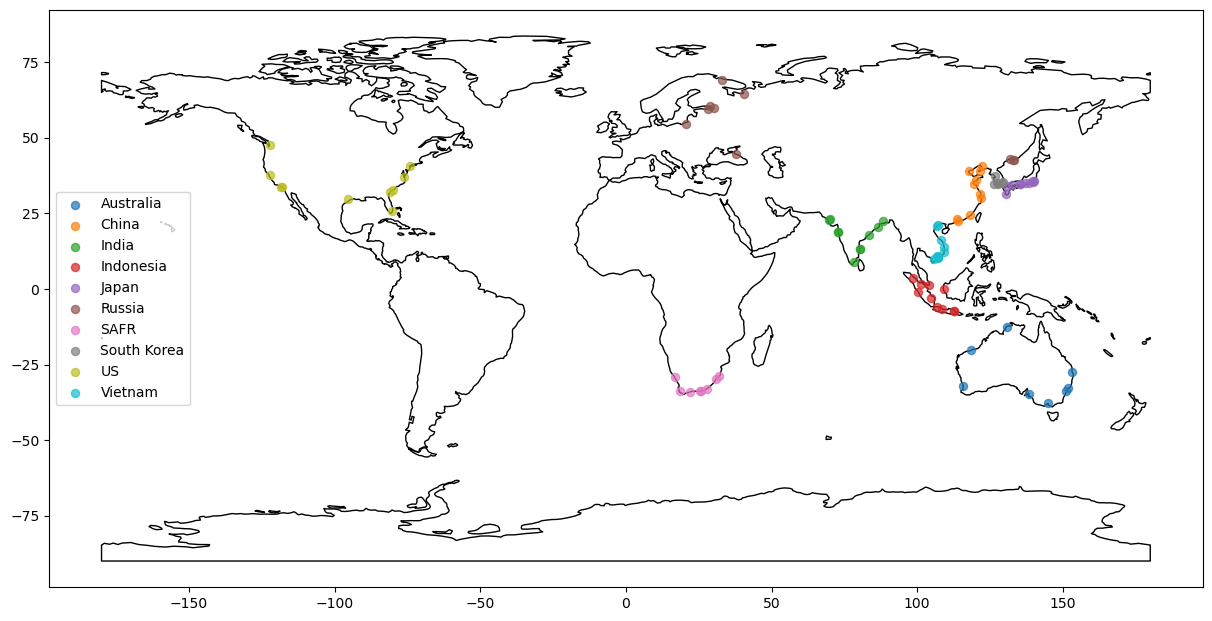

In [17]:
world = geopandas.read_file(get_path("naturalearth.land"))

ax = world.plot(color="white", edgecolor="black", figsize=(15,7.5))

# colormap
nbe_colours = len(ports_list_df.Country.unique())
cm = plt.get_cmap('tab20')
ax.set_prop_cycle(color=[cm(1.*i/nbe_colours) for i in range(nbe_colours)])
# We can now plot our ``GeoDataFrame``

for country, gdf in ports_gdf.groupby('Country'):
    gdf.plot(ax=ax, marker='o', markersize=34, alpha=0.7,
             label=country)

#plt.grid(True)
plt.legend(loc='center left')

for ext in ['.pdf', '.png']:
    plt.savefig(image_world_ports + ext)

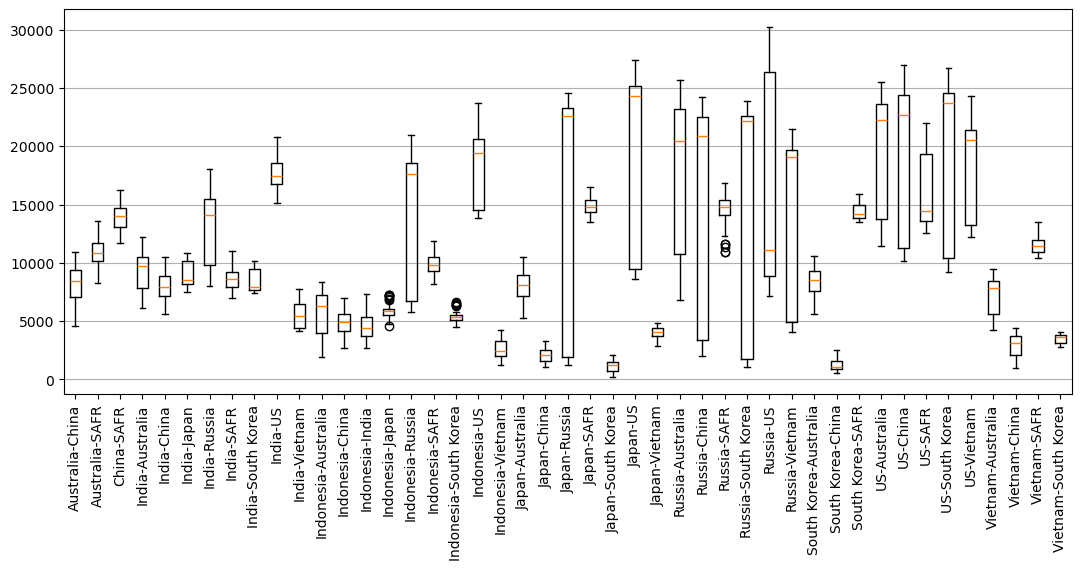

In [18]:
# violinplot

dists_by_country = {
    c12: df.distKM_num for c12, df in all_distances_df.groupby(['c1', 'c2'])
}

f, ax = plt.subplots(figsize=(13,5))

ax.boxplot([df for _, df in dists_by_country.items() ] )

plt.xticks(1+np.arange(len(dists_by_country)), [f"{c1}-{c2}" for (c1, c2) in dists_by_country.keys()], rotation=90)

plt.grid(axis='y')

for ext in ['.pdf', '.png']:
    plt.savefig(image_distrib_distances + ext)